# Compute some timeseries for FOCI-OpenIFS derived output

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.signal import welch, coherence, cwt
from scipy.signal import detrend as sp_detrend
from scipy import signal, stats
import seaborn as sns
import string
from eofs.xarray import Eof

In [2]:
def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
    )

def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

In [3]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)
client

Client Scheduler: tcp://127.0.0.1:46871 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [4]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [33]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_lon = ds_mesh['nav_lon']
da_orca05_lat = ds_mesh['nav_lat']

In [5]:
# To read
exp_list = ['FOCI_GJK001','FOCI_GJK006']
#label_list = ['Warm phase','Cold phase']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','3950-01-01')]

## Barotropic streamfunction

In [6]:
## Read barotropic stream function
ds_psi_all = []

for exp,time in zip(exp_list,time_list):
    
    psi = '%s/%s/derived/nemo/%s*1y*psi.nc' % (esmdir,exp,exp)
    print(psi)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/derived/nemo/FOCI_GJK001*1y*psi.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/derived/nemo/FOCI_GJK006*1y*psi.nc


## Subpolar gyre

In [53]:
spg_amp = []
spg_lon = []
spg_lat = []

for i, ds in enumerate( ds_psi_all[0:1] ):
    
    psi = ds['sobarstf']
    
    jmin, jmax, imin, imax = 350,420,400,600
    
    # find minimum of stream function in subpolar North Atlantic
    _spg_amp = psi[:,jmin:jmax, imin:imax].min(('x','y'))
    
    if 0:
        # find x,y coord of minimum 
        _spg_loc = psi[:,jmin:jmax, imin:imax].argmin(('x','y'))
        
        _spg_lon_1, _spg_lat_1 = [], []
        for j in range(0, 20): #len(psi['time'])):
            _y, _x = _spg_loc['y'][j].values, _spg_loc['x'][j].values
            print(j, _x, _y)
            _spg_lon_1.append( da_orca05_lon[_y, _x] )
            _spg_lat_1.append( da_orca05_lat[_y, _x] )
        
        _spg_lon = xr.DataArray( data=_spg_lon_1, dims=["time"], 
                                 coords=dict(time=psi['time'][0:20]), 
                                 attrs=dict(description="SPG lon", units="degrees_east")
                               )
        
        _spg_lat = xr.DataArray( data=_spg_lat_1, dims=["time"], 
                                 coords=dict(time=psi['time'][0:20]), 
                                 attrs=dict(description="SPG lat", units="degrees_north")
                               )
        
        spg_lon.append(_spg_lon)
        spg_lat.append(_spg_lat)
        
    spg_amp.append(_spg_amp)
    
spg_amp = xr.concat( spg_amp, dim='time' )
#spg_lon = xr.concat( spg_lon, dim='time' )
#spg_lat = xr.concat( spg_lat, dim='time' )

In [55]:
## Save to netcdf
spg_amp.name = 'spg_amp'
ds_amp = spg_amp.to_dataset()
ds_amp.to_netcdf('data/SPG_new_1850_3999.nc')

In [48]:
_y, _x = _spg_loc['y'].values, _spg_loc['x'].values

array([[115.75, 109.25, 108.75, ..., 122.75, 122.75, 122.75],
       [115.75, 109.25, 108.75, ..., 122.75, 122.75, 122.75],
       [115.75, 109.25, 108.75, ..., 122.75, 122.75, 122.75],
       ...,
       [115.75, 109.25, 108.75, ..., 122.75, 122.75, 122.75],
       [115.75, 109.25, 108.75, ..., 122.75, 122.75, 122.75],
       [115.75, 109.25, 108.75, ..., 122.75, 122.75, 122.75]],
      dtype=float32)

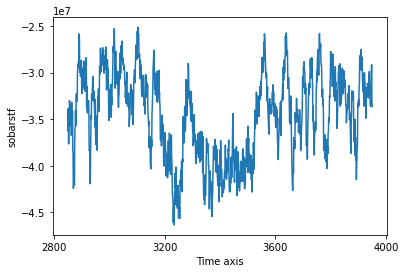

In [31]:
spg_amp.plot()

In [29]:

spg_loc['y'].values

array(46)